# End to End Model Execution

## Prelude

![](../img/tensor_func_linear_relu.png)

Most of the MLC process can be viewed as transformation among tensor functions. The main thing we aim to answer in our following up are:

- What are the possible abstractions to represent the tensor function.
- What are possible transformations among the tensor functions.

In the last lecture, we focus on the primitive tensor functions. In this lecture, we will talk about how to build end-to-end models.

## Preparations

To begin with, we will import necessary dependencies and create helper functions.

In [1]:
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

### Load the Dataset

As a concrete example, we will be using a model on the fashion MNIST dataset. The following code downloads and prepares the data from `torchvision` in NumPy array.

In [2]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|                                                                                                                                                             | 0.00/26.4M [00:00<?, ?B/s]

  0%|▏                                                                                                                                                    | 32.8k/26.4M [00:00<01:55, 229kB/s]

  0%|▎                                                                                                                                                    | 65.5k/26.4M [00:00<01:58, 223kB/s]

  0%|▌                                                                                                                                                    | 98.3k/26.4M [00:00<01:59, 221kB/s]

  1%|█▎                                                                                                                                                    | 229k/26.4M [00:00<00:54, 479kB/s]

  2%|██▍                                                                                                                                                   | 426k/26.4M [00:00<00:32, 808kB/s]

  3%|████▉                                                                                                                                                | 885k/26.4M [00:00<00:16, 1.54MB/s]

  7%|█████████▋                                                                                                                                          | 1.74M/26.4M [00:01<00:08, 2.99MB/s]

 13%|███████████████████▋                                                                                                                                | 3.51M/26.4M [00:01<00:03, 5.85MB/s]

 26%|███████████████████████████████████████                                                                                                             | 6.98M/26.4M [00:01<00:01, 11.4MB/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 10.6M/26.4M [00:01<00:01, 14.3MB/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                | 12.0M/26.4M [00:01<00:01, 12.3MB/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                             | 15.5M/26.4M [00:01<00:00, 16.0MB/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 19.6M/26.4M [00:01<00:00, 18.3MB/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23.2M/26.4M [00:02<00:00, 19.5MB/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 26.4M/26.4M [00:02<00:00, 19.8MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]

  0%|                                                                                                                                                             | 0.00/29.5k [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 195kB/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 193kB/s]

  0%|                                                                                                                                                             | 0.00/4.42M [00:00<?, ?B/s]

  1%|█                                                                                                                                                    | 32.8k/4.42M [00:00<00:20, 219kB/s]

  1%|██▏                                                                                                                                                  | 65.5k/4.42M [00:00<00:20, 218kB/s]

  2%|███▎                                                                                                                                                 | 98.3k/4.42M [00:00<00:19, 217kB/s]

  5%|███████▊                                                                                                                                              | 229k/4.42M [00:00<00:08, 473kB/s]

 10%|██████████████▍                                                                                                                                       | 426k/4.42M [00:00<00:05, 773kB/s]

 19%|████████████████████████████▋                                                                                                                        | 852k/4.42M [00:00<00:02, 1.53MB/s]

 39%|█████████████████████████████████████████████████████████                                                                                           | 1.70M/4.42M [00:01<00:00, 2.91MB/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3.05M/4.42M [00:01<00:00, 4.84MB/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3.54M/4.42M [00:01<00:00, 4.15MB/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4.13M/4.42M [00:01<00:00, 4.10MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 2.91MB/s]

  0%|                                                                                                                                                             | 0.00/5.15k [00:00<?, ?B/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 7.78MB/s]

We can plot out the image instance that we want to be able to predict.

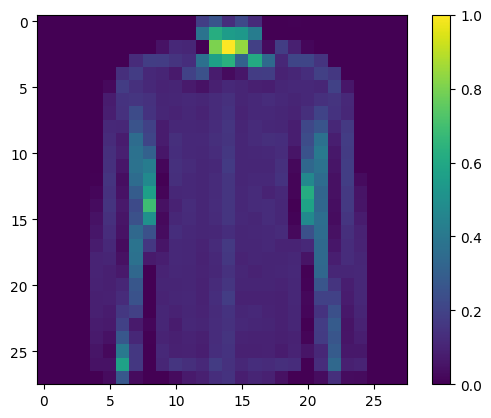

Class: Shirt


In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

### Download Model Parameters

In [4]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2025-07-09 17:33:52--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 

20.87.245.0
Connecting to github.com (github.com)|20.87.245.0|:443... 

connected.


HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2025-07-09 17:33:53--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

connected.
HTTP request sent, awaiting response... 

200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

          fasionmni   0%[                    ]       0  --.-KB/s               

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.1s    

2025-07-09 17:33:54 (3.22 MB/s) - ‘fasionmnist_mlp_params.pkl’ saved [407396/407396]



## End to End Model Integration

In this chapter, we will use the following model as an example. This is a two-layer neural network that consists of two linear operations with relu activation. To keep things simple, we removed the final softmax layer. The output score is un-normalized, but still, the maximum value corresponds to the most likely class.

![](../img/e2e_fashionmnist_mlp_model.png)

Let us begin by reviewing a Numpy implementation of the model.

In [5]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [6]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[-11.469753  -13.756463   -0.5556481  -3.0737486   1.415813   -1.9669425
    6.1600204 -16.645634   -6.9058914 -16.358166 ]]
[6]
NumPy-MLP Prediction: Shirt


The above example code shows the high-level array operations to perform the end-to-end model execution.

Again from MLC's pov, we would like to see through the details under the hood of these array computations.

For the purpose of illustrating details under the hood, we will again write examples in low-level numpy:

- We will use a loop instead of array functions when necessary to demonstrate the possible loop computations.
- When possible, we always explicitly allocate arrays via numpy.empty and pass them around.

The code block below shows a low-level numpy implementation of the same model.

In [7]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Shirt


## Constructing an End to End IRModule in TVMScript

With the low-level NumPy example in mind, now we are ready to introduce an MLC abstraction for the end-to-end model execution. The code block below shows a TVMScript implementation of the model.

In [8]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n), "float32")
        Y = T.match_buffer(y, (1, n), "float32")
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(x: T.handle,
                w: T.handle,
                b: T.handle,
                z: T.handle):
        m, n, k = T.int64(), T.int64(), T.int64()
        X = T.match_buffer(x, (1, m), "float32")
        W = T.match_buffer(w, (n, m), "float32")
        B = T.match_buffer(b, (n, ), "float32")
        Z = T.match_buffer(z, (1, n), "float32")
        Y = T.alloc_buffer((1, n), "float32")
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, "m"), "float32"),
             w0: R.Tensor(("n", "m"), "float32"),
             b0: R.Tensor(("n", ), "float32"),
             w1: R.Tensor(("k", "n"), "float32"),
             b1: R.Tensor(("k", ), "float32")):
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
            lv1 = R.call_dps_packed("relu0", (lv0, ), R.Tensor((1, n), "float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), R.Tensor((1, k), "float32"))
            R.output(out)
        return out

The above code contains kinds of functions: the primitive tensor functions (`T.prim_func`) that we saw in the last lecture and a new `R.function` (relax function). Relax function is a new type of abstraction representing high-level neural network executions.

Again it is helpful to see the TVMScript code and low-level numpy code side-by-side and check the corresponding elements, and we are going to walk through each of them in detail. Since we already learned about primitive tensor functions, we are going to focus on the high-level execution part.

![](../img/e2e_compare_to_lnumpy.png)

### Computational Graph View

![](../img/e2e_computational_graph_call_tir.png)

It is usually helpful to use graph to visualize high-level model executions. The above figure is a graph-view of the `main` function:

- Each of the box in the graph corresponds to computation operations.
- The arrows correspond to the input-output of the intermediate tensors.

We have seen this kind of visualization in earlier lectures. The graph itself can be viewed as a type of abstraction, and it is commonly known as  **computational graph** in machine learning frameworks.


### `call_dps_packed` Construct

One thing that you may have noticed is that each step of operations in the computational graph contains an `R.call_dps_packed` operation. This is the operation that brings in the tensor primitive functions

```python
lv0 = R.call_dps_packed(linear0, (x, w0, b0), (1, 128), dtype="float32")
```


To explain what does `R.call_dps_packed` mean, let us review an equivalent low-level numpy implementation of the operation, as follows:

In [9]:
def lnumpy_call_dps_packed(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res

Specifically, call_dps_packed takes in a primitive function (`prim_func`) a list of inputs. Then what it does is allocate an output tensor `res`, then pass the inputs and the output to the `prim_func`. After executing `prim_func` the result is populated in `res`, then we can return the result.

Note that `lnumpy_call_dps_packed` is only a reference implementation to show the meaning of `R.call_dps_packed`. In practice, there can be different low-level ways to optimize the execution. For example, we might choose to allocate all the output memories ahead of time and then run the execution, which we will cover in future lectures.

A natural question that one could ask is why do we need `call_dps_packed` construct? This is because our primitive tensor functions take the following calling convention.

```python
def low_level_prim_func(in0, in1, ..., out):
    # implementations
```


This convention is called **destination passing**. The idea is that input and output are explicitly allocated outside and passed to the low-level primitive function. This style is commonly used in low-level library designs, so higher-level frameworks can handle that memory allocation decision. Note that not all tensor operations can be presented in this style (specifically, there are operations whose output shape depends on the input). Nevertheless, in common practice, it is usually helpful to write the low-level function in this style when possible.

While it is possible to assemble the destination passing convention function together by explicitly allocating intermediate results and calling each function, it is hard to turn the following code into computational graph form.

```python
def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out
```


![](../img/e2e_computational_graph_numpy.png)

We can certainly try a bit :) The above figure is one possible "failed attempt" to fit the `lnumpy_mlp` into a "computational graph-like" form by simply connecting function inputs to the function.

We can find that it lost a few nice properties of the previous computational graphs. Specifically,  a computational graph usually has the following properties

- Every input edge to the box corresponds to the input to the operation.
- Every outgoing edge corresponds to the output of the operations.
- Each operation can be reordered arbitrarily up to the topological order of the edges.

Of course, we can still generalize the graph definition by introducing the input edge and output edge, and that can complicate the possible transformations associated with the abstraction.

So coming back to `call_dps_packed`, the key insight here is that we want to hide possible allocation or explicit writing to the functions. In a more formal term, we want the function to be **pure** or **side-effect free**.

A function is **pure** or **side-effect free** if: it only reads from its inputs and returns the result via its output, it will not change other parts of the program (such as incrementing a global counter).

**call_dps_packed** is a way for us to hide these details of calling into low-level primitive functions and expose them into a computational graph.

We can also see `call_dps_packed` in action in the low-level numpy as well. Now we have defined the `lnumpy_call_dps_packed`, we can rewrite the low-level numpy execution code as:

In [10]:
def lnumpy_mlp_with_call_dps_packed(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_dps_packed(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_dps_packed(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_dps_packed(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

result = lnumpy_mlp_with_call_dps_packed(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = np.argmax(result, axis=1)
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: Shirt


In practice, the lowest-level implementation will have explicit memory allocations, so `call_dps_packed` mainly serves as a purpose for us to continue to do some high-level transformations before we generate the actual implementation.

### Dataflow Block

Another important element in a relax function is the `R.dataflow()` scope annotation.

```python
with R.dataflow():
    lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
    lv1 = R.call_dps_packed("relu0", (lv0, ), R.Tensor((1, n), "float32"))
    out = R.call_dps_packed("linear0", (lv1, w1, b1), R.Tensor((1, k), "float32"))
    R.output(out)
```


This connects back to the **computational graph** discussion we had in the last section. Recall that ideally, each computational graph operation should be side effect free.

What if we still want to introduce operations that contains side effect? A dataflow block is a way for us to mark the computational graph regions of the program. Specifically, within a dataflow block, all the operations need to be side-effect free. Outside a dataflow block, the operations can contain side-effect. The program below is an example program that contains two dataflow blocks.

```python
@R.function
def main(x: R.Tensor((1, "m"), "float32"),
        w0: R.Tensor(("n", "m"), "float32"),
        b0: R.Tensor(("n", ), "float32"),
        w1: R.Tensor(("k", "n"), "float32"),
        b1: R.Tensor(("k", ), "float32")):
    m, n, k = T.int64(), T.int64(), T.int64()

    with R.dataflow():
        lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
        gv0 = R.call_dps_packed("relu0", (lv0, ), R.Tensor((1, n), "float32"))
        R.output(gv0)

    with R.dataflow():
        out = R.call_dps_packed("linear0", (gv0, w1, b1), R.Tensor((1, k), "float32"))
        R.output(out)
    return out
```


Most of our lectures will only deal with computational graphs (dataflow blocks). But it is good to keep the reason behind in mind.

### Section Checkpoint

So far, we have gone through one example instance of relax program and covered most of the elements, including:

- Computational graph view
- `call_dps_packed` construct
- Dataflow block.

These elements should get us started in the end to end model execution and compilation. we will also cover new concepts as we encounter them in later chapters.

## Build and Run the Model

In the last section, we discussed the abstraction that enables us to represent end-to-end model execution. This section introduces how to build and run an IRModule. Let us begin by reviewing the IRModule we have.

In [11]:
IPython.display.Code(MyModule.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def linear0(x: T.handle, w: T.handle, b: T.handle, z: T.handle):
        m = T.int64()
        X = T.match_buffer(x, (1, m))
        n = T.int64()
        W = T.match_buffer(w, (n, m))
        B = T.match_buffer(b, (n,))
        Z = T.match_buffer(z, (1, n))
        # with T.block("root"):
        Y = T.alloc_buffer((1, n))
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0.0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n))
        Y = T.match_buffer(y, (1, n))
        # with T.block("root"):
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0.0))

    @R.function
    def main(x: R.Tensor((1, "m"), dtype="float32"), w0: R.Tensor(("n", "m"), dtype="float32"), b0: R.Tensor(("n",), dtype="float32"), w1: R.Tensor(("k", "n"), dtype="float32"), b1: R.Tensor(("k",), dtype="float32")) -> R.Tensor((1, "k"), dtype="float32"):
        k = T.int64()
        m = T.int64()
        n = T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), out_sinfo=R.Tensor((1, n), dtype="float32"))
            lv1 = R.call_dps_packed("relu0", (lv0,), out_sinfo=R.Tensor((1, n), dtype="float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), out_sinfo=R.Tensor((1, k), dtype="float32"))
            R.output(out)
        return out

We call `relax.build` to build this function. Relax is still under development, so some of the APIs may change. Our main goal, though, is to get familiar with the overall MLC flow (Construct, transform, build) for end-to-end models.

In [12]:
ex = relax.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm_build.VMExecutable

The build function will give us an executable. We can initialize a virtual machine executor that enables us to run the function. Additionally, we will pass in a second argument, indicating which device we want to run the end-to-end executions on.

In [13]:
vm = relax.VirtualMachine(ex, tvm.cpu())

Now we are ready to run the model. We begin by constructing tvm NDArray that contains input data and weights.

In [14]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

Then we can run the main function by passing in the input arguments and weights.

In [15]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

[[-11.469754  -13.756463   -0.555647   -3.0737479   1.4158127  -1.9669449
    6.16002   -16.645632   -6.9058924 -16.358166 ]]


The main function returns the prediction result, and we can then call `nd_res.numpy()` to convert it to numpy array, and take argmax to get the class label.

In [16]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Shirt


## Integrate Existing Libraries in the Environment

In the last section, we showed how to build an IRModule that contains both the primitive function implementations as well as the high-level computational graph part. In many cases, we may be interested in integrating existing library functions into the MLC process.

The IRModule shows an example on how to do that.

In [17]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: R.Tensor((1, "m"), "float32"),
             w0: R.Tensor(("n", "m"), "float32"),
             b0: R.Tensor(("n", ), "float32"),
             w1: R.Tensor(("k", "n"), "float32"),
             b1: R.Tensor(("k", ), "float32")):
        # block 0
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("env.linear", (x, w0, b0), R.Tensor((1, n), "float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0, ), R.Tensor((1, n), "float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, k), "float32"))
            R.output(out)
        return out

Note that we now directly pass in strings in `call_dps_packed`

```python
R.call_dps_packed("env.linear", (x, w0, b0), R.Tensor((1, n), "float32"))
```


These strings are names of runtime functions that we expect to exist during model execution.

### Registering Runtime Function

In order to be able to execute the code that calls into external functions, we need to register the corresponding functions. The code block below registers two implementations of the functions.

In [18]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In the above code, we use the `from_dlpack` to convert a TVM NDArray to a torch NDArray. Note that this is a zero-copy conversion, which means the torch array shares the underlying memory with the TVM NDArray. DLPack is a common exchange standard that allows different frameworks to exchange Tensor/NDArray without being involved in data copy. The `from_dlpack` API is supported by multiple frameworks and is part of the python array API standard. If you are interested, you can read more [here](https://dmlc.github.io/dlpack/latest/python_spec.html).

In this particular function, we simply piggyback  PyTorch's implementation. In real-world settings, we can use a similar mechanism to redirect calls onto specific libraries, such as cuDNN or our own library implementations.

This particular example performs the registration in python. In reality, we can register functions in different languages (such as C++) that do not have a python dependency. We will cover more in future lectures.

### Build and Run

Now we can build and run `MyModuleWithExternCall`, and we can verify that we get the same result.

In [19]:
ex = relax.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Shirt


## Mixing TensorIR Code and Libraries

In the last example, we build an IRModule where all primitive operations are dispatched to library functions. Sometimes it can be helpful to have a mixture of both.

In [20]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(x: T.handle,
                w: T.handle,
                b: T.handle,
                z: T.handle):
        m, n, k = T.int64(), T.int64(), T.int64()
        X = T.match_buffer(x, (1, m), "float32")
        W = T.match_buffer(w, (n, m), "float32")
        B = T.match_buffer(b, (n, ), "float32")
        Z = T.match_buffer(z, (1, n), "float32")
        Y = T.alloc_buffer((1, n), "float32")
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, "m"), "float32"),
             w0: R.Tensor(("n", "m"), "float32"),
             b0: R.Tensor(("n", ), "float32"),
             w1: R.Tensor(("k", "n"), "float32"),
             b1: R.Tensor(("k", ), "float32")):
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0, ), R.Tensor((1, n), "float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, k), "float32"))
            R.output(out)
        return out

The above code block shows an example where linear0 is still implemented in TensorIR, while the rest of the functions are redirected to library functions. We can build and run to validate the result.

In [21]:
ex = relax.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Shirt


## Bind Parameters to IRModule

In all the examples so far, we construct the main function by passing in the parameters explicitly. In many cases, it is usually helpful to bind the parameters as constants attached to the IRModule. The following code created the binding by matching the parameter names to the keys in nd_params.

In [22]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
IPython.display.Code(MyModuleWithParams.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def linear0(x: T.handle, w: T.handle, b: T.handle, z: T.handle):
        m = T.int64()
        X = T.match_buffer(x, (1, m))
        n = T.int64()
        W = T.match_buffer(w, (n, m))
        B = T.match_buffer(b, (n,))
        Z = T.match_buffer(z, (1, n))
        # with T.block("root"):
        Y = T.alloc_buffer((1, n))
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0.0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, metadata["relax.expr.Constant"][0], metadata["relax.expr.Constant"][1]), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, metadata["relax.expr.Constant"][2], metadata["relax.expr.Constant"][3]), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

# Metadata omitted. Use show_meta=True in script() method to show it.

In the above script, `meta[relay.Constant][0]` corresponds to an implicit dictionary that stores the constant (which is not shown as part of the script but still is part of the IRModule). If we build the transformed IRModule, we can now invoke the function by just passing in the input data.

In [23]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Shirt


## Discussions

In this chapter, we have discussed many ways to describe the end-to-end model execution. One thing we may have noticed is that we are coming back to the theme of **abstraction and implementation**

- Both the TensorIR function and library functions follow the same destination passing style. As a result, we can simply replace invocation from one to another in our examples.
- We may use different ways to represent the computation at different stages of the MLC process.

So far, we have touched on a few ways to transform the end-to-end IRModule (e.g. parameter binding). Let us come back to the following common theme of MLC: MLC process is about representing the execution in possibly different abstractions and transforming among them.

![](../img/mlc_process.png)

There are many possible transformations in the end-to-end execution. For example, we can take the TensorIR function in MyModuleMixture and change the `linear0` function using the schedule operations taught in the last lecture. In other instances, we might want to transform high-level model executions into a mixture of library function calls and TensorIR functions.

As an exercise, spend some time thinking about what kinds of transformations you might want to perform on an IRModule. We will also cover more transformations in the future.

In this chapter, we construct the IRModule by hand. In practice, a real neural network model can contain hundreds of layers, so it is infeasible to write things out manually. Still, the script format is helpful for us to peek into what is going on and do interactive developments. We will also learn about more ways to construct IRModule in future episodes programmatically.

## Summary
- Computational graph abstraction helps to stitch primitive tensor functions together for end-to-end execution.
- Key elements of relax abstraction include
  - call_dps_packed construct that embeds destination passing style primitive function into the computational graph
  - dataflow block
- Computational graph allows call into both environment library functions and TensorIR functions.